# Computing tilt angle for active regions

22 Dec 2025

In this notebook, I build a code for calculating solar active region tilt angles based on the flux weighted barycenters of the positive and negative polarities. SDO/HMI line-of-sight magnetogram data has been used for the same. Perhaps this code is more efficient for bipolar acitve regions and might not be suitable for multi polar complex activity regions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.path import Path

from astropy.io import fits
import sunpy.map as m

import math
from skimage import measure
import glob
import os
import datetime

In [2]:
os.getcwd()

'C:\\Users\\priya\\Work\\Projects\\zzmisc\\AR tilt calculation\\jupyter notebooks'

In [3]:
main_dir = 'C:/Users/priya/Work/Projects/zzmisc/AR tilt calculation/'

In [4]:
HARP_folders = glob.glob(os.path.join(main_dir, 'data/*'))
HARPNUMs = []

for ii in HARP_folders:
    HARPNUMs.append(ii[-5 : ])

HARPNUMs

['13171',
 '13561',
 '13641',
 '13773',
 '13777',
 '13845',
 '13866',
 '13876',
 '14003']

In [5]:
glob.glob(main_dir + 'data/13866/*')

['C:/Users/priya/Work/Projects/zzmisc/AR tilt calculation/data/13866\\hmi.sharp_cea_720s.13866.20251009_140000_TAI.bitmap.fits',
 'C:/Users/priya/Work/Projects/zzmisc/AR tilt calculation/data/13866\\hmi.sharp_cea_720s.13866.20251009_140000_TAI.Br.fits',
 'C:/Users/priya/Work/Projects/zzmisc/AR tilt calculation/data/13866\\hmi.sharp_cea_720s.13866.20251009_140000_TAI.conf_disambig.fits',
 'C:/Users/priya/Work/Projects/zzmisc/AR tilt calculation/data/13866\\hmi.sharp_cea_720s.13866.20251009_140000_TAI.continuum.fits',
 'C:/Users/priya/Work/Projects/zzmisc/AR tilt calculation/data/13866\\hmi.sharp_cea_720s.13866.20251009_140000_TAI.magnetogram.fits']

### loading fits files

In [6]:
print(HARPNUMs)

['13171', '13561', '13641', '13773', '13777', '13845', '13866', '13876', '14003']


In [7]:
jj = -3
print(HARPNUMs[jj] + '\n')

magnetogram_13866_fits   = glob.glob(os.path.join(HARP_folders[jj], '*magnetogram.fits'))[0]

13866



In [8]:
jj = -2
print(HARPNUMs[jj] + '\n')

magnetogram_13876_fits   = glob.glob(os.path.join(HARP_folders[jj], '*magnetogram.fits'))[0]

13876



### extracting fits content

In [9]:
magnetogram_13866        = fits.open(magnetogram_13866_fits)[1]
magnetogram_13866.data   = np.flipud(magnetogram_13866.data)

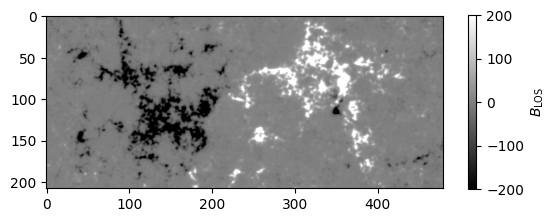

In [10]:
plt.imshow(magnetogram_13866.data, cmap = 'gray', vmin = -200, vmax = 200)

plt.colorbar(label = '$B_{\mathrm{LOS}}$', shrink = 0.47)
plt.show()

In [11]:
magnetogram_13876        = fits.open(magnetogram_13876_fits)[1]
magnetogram_13876.data   = np.flipud(magnetogram_13876.data)

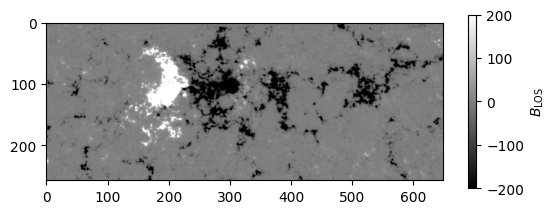

In [12]:
plt.imshow(magnetogram_13876.data, cmap = 'gray', vmin = -200, vmax = 200)

plt.colorbar(label = '$B_{\mathrm{LOS}}$', shrink = 0.47)
plt.show()

### contouring strong field regions to generate masks

In [13]:
def contouring_strongfieldregions(data, threshold, plot=0):
    
    threshold_val = threshold

    contours_pos = measure.find_contours(data, threshold_val)
    contours_neg = measure.find_contours(-data, threshold_val)
    
    if plot == 1:
        print(f"B_max = {data.max() : 0.2f}")
        print(f"B_min = {data.min() : 0.2f}")
        
        fig, ax = plt.subplots(1, 1)

        img = ax.imshow(data, cmap = 'gray',  vmin = -200, vmax = 200)
        plt.colorbar(img, shrink = 0.47)


        # contour for positive polarity
        for contour in contours_pos:
            ax.plot(contour[:, 1], contour[:, 0], color = 'b')


        # contour for negative polarity
        for contour in contours_neg:
            ax.plot(contour[:, 1], contour[:, 0], color = 'r')
    
    # building positive mask
    masks_pos = []
    mask_pos = np.zeros(data.shape, dtype = bool)

    for ii in range(len(contours_pos)):
        if len(contours_pos[ii]) > 0:
            path     = Path(contours_pos[ii])
            y, x     = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]), indexing = 'ij')
            points   = np.vstack((y.ravel(), x.ravel())).T
            mask_pos = path.contains_points(points).reshape(data.shape)

            masks_pos.append(mask_pos)

    total_pos_mask = masks_pos[0]

    for jj in range(1, len(masks_pos)):
        total_pos_mask = np.logical_or(total_pos_mask, masks_pos[jj])

    total_pos_mask_disp = np.ones_like(total_pos_mask) * np.nan
    total_pos_mask_disp[total_pos_mask == True] = 1


    # building negative mask
    masks_neg = []
    mask_neg = np.zeros(data.shape, dtype = bool)

    for ii in range(len(contours_neg)):
        if len(contours_neg[ii]) > 0:
            path     = Path(contours_neg[ii])
            y, x     = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]), indexing = 'ij')
            points   = np.vstack((y.ravel(), x.ravel())).T
            mask_neg = path.contains_points(points).reshape(data.shape)

            masks_neg.append(mask_neg)

    total_neg_mask = masks_neg[0]

    for jj in range(1, len(masks_neg)):
        total_neg_mask = np.logical_or(total_neg_mask, masks_neg[jj])

    total_neg_mask_disp = np.ones_like(total_neg_mask) * np.nan
    total_neg_mask_disp[total_neg_mask == True] = 1
    
    return [total_neg_mask, total_neg_mask_disp, total_pos_mask, total_pos_mask_disp]

### finding flux-weighted centers for the positive and negative polarities

In [14]:
def fluxweighted_center(data, total_neg_mask_disp, total_pos_mask_disp, plot=0):
    B  = data
    nx = data.shape[1]   # number of columns (horizontal)
    ny = data.shape[0]   # number of rows (vertical)

    ##
    # positive polarity's flux weighted center

    dxBsum_pos = 0
    Bsum_x_pos = 0

    dyBsum_pos = 0
    Bsum_y_pos = 0

    x_fw_pos = 0
    y_fw_pos = 0

    for i in range(1, nx-1):   # horizontal
        for j in range(1, ny-1):   # vertical
            if np.isnan(total_pos_mask_disp[j, i]):
                continue
            if np.isnan(B[j, i]):
                continue

            dxBsum_pos += (0.5 + i) * B[j, i]
            Bsum_x_pos += B[j, i]

            dyBsum_pos += (0.5 + j) * B[j, i]
            Bsum_y_pos += B[j, i]

    # leftmost column
    i = 0
    for j in range(0, ny):
        if np.isnan(total_pos_mask_disp[j, i]):
            continue
        if np.isnan(B[j, i]):
            continue

        dxBsum_pos += 0.5 * B[j, i]
        Bsum_x_pos += B[j, i]

    # rightmost column
    i = nx - 1
    for j in range(0, ny):
        if np.isnan(total_pos_mask_disp[j, i]):
            continue
        if np.isnan(B[j, i]):
            continue

        dxBsum_pos += 0.5 * B[j, i]
        Bsum_x_pos += B[j, i]

    # topmost row
    j = 0
    for i in range(0, nx):
        if np.isnan(total_pos_mask_disp[j, i]):
            continue
        if np.isnan(B[j, i]):
            continue

        dxBsum_pos += 0.5 * B[j, i]
        Bsum_x_pos += B[j, i]

    # bottom-most row
    j = ny - 1
    for i in range(0, nx):
        if np.isnan(total_pos_mask_disp[j ,i]):
            continue
        if np.isnan(B[j, i]):
            continue

        dxBsum_pos += 0.5 * B[j, i]
        Bsum_x_pos += B[j, i]

    x_fw_pos = dxBsum_pos / Bsum_x_pos
    y_fw_pos = dyBsum_pos / Bsum_y_pos   # be careful about the origin of the plot window



    ##
    # negative polarity's flux weighted center

    dxBsum_neg = 0
    Bsum_x_neg = 0

    dyBsum_neg = 0
    Bsum_y_neg = 0

    x_fw_neg = 0
    y_fw_neg = 0

    for i in range(1, nx-1):   # horizontal
        for j in range(1, ny-1):   # vertical
            if np.isnan(total_neg_mask_disp[j, i]):
                continue
            if np.isnan(B[j, i]):
                continue

            dxBsum_neg += (0.5 + i) * B[j, i]
            Bsum_x_neg += B[j, i]

            dyBsum_neg += (0.5 + j) * B[j, i]
            Bsum_y_neg += B[j, i]

    # leftmost column
    i = 0
    for j in range(0, ny):
        if np.isnan(total_neg_mask_disp[j, i]):
            continue
        if np.isnan(B[j, i]):
            continue

        dxBsum_neg += 0.5 * B[j, i]
        Bsum_x_neg += B[j, i]

    # rightmost column
    i = nx - 1
    for j in range(0, ny):
        if np.isnan(total_neg_mask_disp[j, i]):
            continue
        if np.isnan(B[j, i]):
            continue

        dxBsum_neg += 0.5 * B[j, i]
        Bsum_x_neg += B[j, i]

    # topmost row
    j = 0
    for i in range(0, nx):
        if np.isnan(total_neg_mask_disp[j, i]):
            continue
        if np.isnan(B[j, i]):
            continue

        dxBsum_neg += 0.5 * B[j, i]
        Bsum_x_neg += B[j, i]

    # bottom-most row
    j = ny - 1
    for i in range(0, nx):
        if np.isnan(total_neg_mask_disp[j ,i]):
            continue
        if np.isnan(B[j, i]):
            continue

        dxBsum_neg += 0.5 * B[j, i]
        Bsum_x_neg += B[j, i]

    x_fw_neg = dxBsum_neg / Bsum_x_neg
    y_fw_neg = dyBsum_neg / Bsum_y_neg   # be careful about the origin of the plot window

    x_fw, y_fw = [x_fw_pos, x_fw_neg], [y_fw_pos, y_fw_neg]

    if plot == 1:
        
        # plot window
        fig, ax = plt.subplots(1, 1, dpi = 150)

        fig = ax.imshow(B, cmap = 'gray', vmin = -200, vmax = 200)
        plt.colorbar(fig, shrink = 0.47)

        ax.imshow(total_pos_mask_disp, cmap = 'Blues', vmin = 0.8, vmax = 1.2)
        ax.imshow(total_neg_mask_disp, cmap = 'Reds', vmin = 0.8, vmax = 1.2)


        ax.plot(x_fw[0], y_fw[0], 'o', color = 'k', ms = 10)
        ax.plot(x_fw[0], y_fw[0], 'o', color = 'b', ms = 8)

        ax.plot(x_fw[1], y_fw[1], marker = 'x', mec = 'k', mfc = 'r', ms = 10, mew = 4)
        ax.plot(x_fw[1], y_fw[1], marker = 'x', mec = 'r', mfc = 'r', ms = 9, mew = 2)

        ax.plot(x_fw, y_fw, ls = '--', color = 'lime')
    
    return x_fw, y_fw

### Computing tilt angle of the active region from the calculated flux weighted centers

In [15]:
radsindeg = np.pi / 180
cdelt1_arcsec = (math.atan( (magnetogram_13866.header['rsun_ref'] * magnetogram_13866.header['cdelt1'] * radsindeg) / (magnetogram_13866.header['dsun_obs']) )) * (1 / radsindeg) * 3600   # pixel lenght in arcsec as viewed by the observer
dpix = cdelt1_arcsec * (magnetogram_13866.header['rsun_ref'] / magnetogram_13866.header['rsun_obs'])
print(f"1 px = {dpix:0.2f} m")

1 px = 364423.41 m


In [16]:
def computeTilt(magnetogram, SC):
    
    mag = magnetogram
    
    if mag.header['LAT_FWT'] >= 0:
        hem = 'N'
    if mag.header['LAT_FWT'] < 0:
        hem = 'S'
    
    total_neg_mask_AR, total_neg_mask_disp_AR, total_pos_mask_AR, total_pos_mask_disp_AR = contouring_strongfieldregions(mag.data, threshold = 400)
    
    x_fw, y_fw = fluxweighted_center(mag.data, total_neg_mask_disp_AR, total_pos_mask_disp_AR)
    
    data = [mag.header['HARPNUM'], mag.header['NOAA_AR'], SC, hem, x_fw[1], y_fw[1], x_fw[0], y_fw[0], dpix, 'False', 'False', 0, 0]
    columns = ['HARPNUM', 'NOAA_AR', 'Solar Cycle', 'Hemisphere', 'x_fw_neg [px]', 'y_fw_neg [px]', 'x_fw_pos [px]', 'y_fw_pos [px]', 'dpix [m]', 'HALEness', 'JOYness', 'Absolute Tilt', 'Relative Tilt']

    df_main = pd.DataFrame(data = [data], columns = columns)

    HH = False
    JJ = False

    df = df_main.copy()

    ## Determining HALEness and JOYness

    # Odd solar cycle
    if np.mod(df['Solar Cycle'].iloc[0], 2) != 0:
        
        # Northern hemisphere
        if df['Hemisphere'].iloc[0] == 'N':
            
            if df['x_fw_pos [px]'].iloc[0] >= df['x_fw_neg [px]'].iloc[0]:
                HH = True
                
                if df['y_fw_pos [px]'].iloc[0] >= df['y_fw_neg [px]'].iloc[0]:
                    JJ = True
            else:                
                if df['y_fw_pos [px]'].iloc[0] <= df['y_fw_neg [px]'].iloc[0]:
                    JJ = True
                    
        # Southern hemisphere
        if df['Hemisphere'].iloc[0] == 'S':
            
            if df['x_fw_pos [px]'].iloc[0] <= df['x_fw_neg [px]'].iloc[0]:
                HH = True

                if df['y_fw_pos [px]'].iloc[0] >= df['y_fw_neg [px]'].iloc[0]:
                    JJ = True
            
            else:                
                if df['y_fw_pos [px]'].iloc[0] <= df['y_fw_neg [px]'].iloc[0]:
                    JJ = True


    # Even solar cycle   
    elif np.mod(df['Solar Cycle'].iloc[0], 2) == 0:
        
        # Northern hemisphere
        if df['Hemisphere'].iloc[0] == 'N':
            
            if df['x_fw_pos [px]'].iloc[0] <= df['x_fw_neg [px]'].iloc[0]:
                HH = True
                
                if df['y_fw_pos [px]'].iloc[0] <= df['y_fw_neg [px]'].iloc[0]:
                    JJ = True
                
            else:              
                if df['y_fw_pos [px]'].iloc[0] >= df['y_fw_neg [px]'].iloc[0]:
                    JJ = True
                
        # Southern hemisphere
        if df['Hemisphere'].iloc[0] == 'S':
            
            if df['x_fw_pos [px]'].iloc[0] >= df['x_fw_neg [px]'].iloc[0]:
                HH = True
                
                if df['y_fw_neg [px]'].iloc[0] >= df['y_fw_neg [px]'].iloc[0]:
                    JJ = True
            
            else:                
                if df['y_fw_neg [px]'].iloc[0] <= df['y_fw_pos [px]'].iloc[0]:
                    JJ = True

    df_main.loc[0, 'HALEness'] = HH
    df_main.loc[0, 'JOYness']  = JJ


    # Tilt angle calculation

    dx_fw = np.abs(df_main['x_fw_neg [px]'].iloc[0] - df_main['x_fw_pos [px]'].iloc[0])
    dy_fw = np.abs(df_main['y_fw_neg [px]'].iloc[0] - df_main['y_fw_pos [px]'].iloc[0]) 

    alpha = math.atan(dy_fw / dx_fw) * (180 / np.pi)

    T_rel = 0
    T_abs = 0
    
    # Odd solar cycle
    if np.mod(df['Solar Cycle'].iloc[0], 2) != 0:
        
        # Northern hemisphere
        if df['Hemisphere'].iloc[0] == 'N':
            
            if JJ == True:

                T_rel = 180 - alpha

                if HH == True:
                    T_abs = -alpha

                elif HH == False:
                    T_abs = T_rel

            elif JJ == False:

                T_rel = -(180 - alpha)

                if HH == True:
                    T_abs = alpha

                elif HH == False:
                    T_abs = T_rel
        
        # Southern hemisphere
        elif df['Hemisphere'].iloc[0] == 'S':
            
            if JJ == True:
                
                T_rel = -(180 - alpha)
                
                if HH == True:
                    T_abs = T_rel
                
                elif HH == False:
                    T_abs = alpha
            
            elif JJ == False:
                
                T_rel = 180 - alpha
                
                if HH == True:
                    T_abs = T_rel
                
                elif HH == False:
                    T_abs = -alpha
    
    # Even solar cycle
    elif np.mod(df['Solar Cycle'].iloc[0], 2) == 0:
        
        # Northern hemisphere
        if df['Hemisphere'].iloc[0] == 'N':
            
            if JJ == True:
                
                T_rel = 180 - alpha
                
                if HH == True:
                    T_abs = T_rel
                
                elif HH == False:
                    T_abs = -alpha
                    
            elif JJ == False:
                
                T_rel = -(180 - alpha)
                
                if HH == True:
                    T_abs = T_rel
                
                elif HH == False:
                    T_abs = alpha
        
        # Southern hemisphere
        elif df['Hemisphere'].iloc[0] == 'S':
            
            if JJ == True:
                
                T_rel = -(180 - alpha)
                
                if HH == True:
                    T_abs = alpha
                    
                elif HH == False:
                    T_abs = T_rel
            
            elif JJ == False:
                
                T_rel = 180 - alpha
                
                if HH == True:
                    T_abs = -alpha
                
                elif HH == False:
                    T_abs = T_rel
            

    df_main.loc[0, 'Absolute Tilt'] = T_abs
    df_main.loc[0, 'Relative Tilt'] = T_rel

    return df_main

### 1. `HARP 13866 | NOAA 14243` cycle 25 N, Hale antiJoy (HH-AJ)

B_max =  1116.50
B_min = -870.30


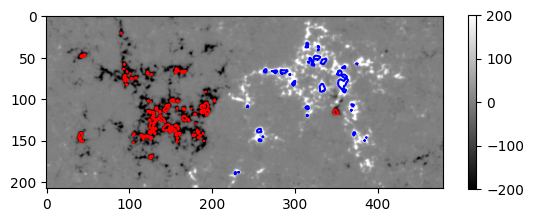

In [17]:
total_neg_mask_13866, total_neg_mask_disp_13866, total_pos_mask_13866, total_pos_mask_disp_13866 = contouring_strongfieldregions(magnetogram_13866.data, 400, plot = 1)

fw pos center: 330.12, 79.39
fw neg center: 150.36, 119.25


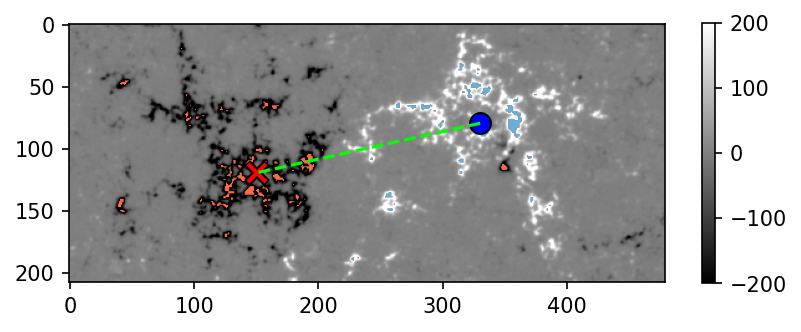

In [18]:
x_fw_13866, y_fw_13866 = fluxweighted_center(magnetogram_13866.data, total_neg_mask_disp_13866, total_pos_mask_disp_13866, plot = 1)

x_fw_13866_pos, x_fw_13866_neg = x_fw_13866[0], x_fw_13866[1]
y_fw_13866_pos, y_fw_13866_neg = y_fw_13866[0], y_fw_13866[1]

print(f"fw pos center: {x_fw_13866_pos :0.2f}, {y_fw_13866_pos :0.2f}")
print(f"fw neg center: {x_fw_13866_neg :0.2f}, {y_fw_13866_neg :0.2f}")

In [19]:
df_13866 = computeTilt(magnetogram_13866, 25)
df_13866

,HARPNUM,NOAA_AR,Solar Cycle,Hemisphere,x_fw_neg [px],y_fw_neg [px],x_fw_pos [px],y_fw_pos [px],dpix [m],HALEness,JOYness,Absolute Tilt,Relative Tilt
0,13866,14243,25,N,150.359952,119.249493,330.124879,79.394889,364423.407419,True,False,12.50051,-167.49949


### 2. `HARP 13876 | NOAA 14247` cycle 25 S, Hale Joy (HH-JJ)

B_max =  1420.20
B_min = -1487.60


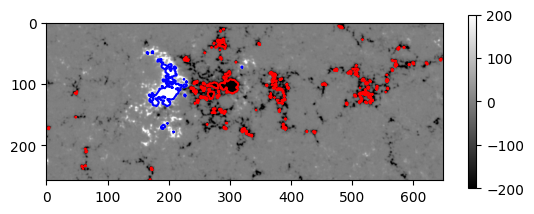

In [20]:
total_neg_mask_13876, total_neg_mask_disp_13876, total_pos_mask_13876, total_pos_mask_disp_13876 = contouring_strongfieldregions(magnetogram_13876.data, 400, plot = 1)

fw pos center: 198.22, 108.42
fw neg center: 336.57, 102.91


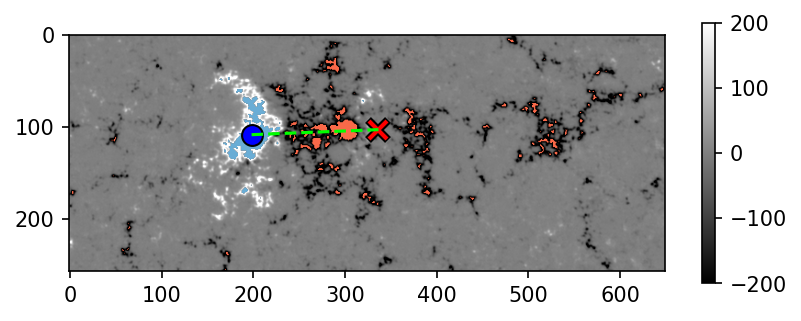

In [21]:
x_fw_13876, y_fw_13876 = fluxweighted_center(magnetogram_13876.data, total_neg_mask_disp_13876, total_pos_mask_disp_13876, plot = 1)

x_fw_13876_pos, x_fw_13876_neg = x_fw_13876[0], x_fw_13876[1]
y_fw_13876_pos, y_fw_13876_neg = y_fw_13876[0], y_fw_13876[1]

print(f"fw pos center: {x_fw_13876_pos :0.2f}, {y_fw_13876_pos :0.2f}")
print(f"fw neg center: {x_fw_13876_neg :0.2f}, {y_fw_13876_neg :0.2f}")

In [22]:
df_13876 = computeTilt(magnetogram_13876, 25)
df_13876

,HARPNUM,NOAA_AR,Solar Cycle,Hemisphere,x_fw_neg [px],y_fw_neg [px],x_fw_pos [px],y_fw_pos [px],dpix [m],HALEness,JOYness,Absolute Tilt,Relative Tilt
0,13876,14247,25,S,336.569601,102.905766,198.221455,108.417332,364423.407419,True,True,-177.718635,-177.718635
